In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
   
def rgb2bgr(img):
    for i in range(len(img)):
        for j in range(len(img[0])):
            img[i][j][0], img[i][j][2] = img[i][j][2], img[i][j][0] # BGR -> RGB
    return img

f="11W86000383015312LKF070_1619408007_11W86000383015312LKF070_SA-AOI-TRIM_2021-04-26-11-33-27_org.jpg"

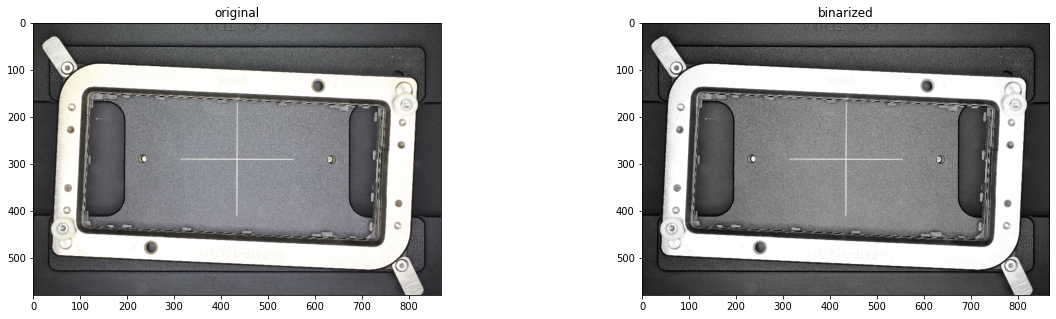

In [34]:
img0 = cv2.imread(r"C:\Users\James\Desktop\phone_data\data\\"+f)
img = cv2.resize(img0, (img0.shape[1]//10, img0.shape[0]//10))
imgGray = cv2.imread(r"C:\Users\James\Desktop\phone_data\data\\"+f, cv2.IMREAD_GRAYSCALE)
imgGray = cv2.resize(imgGray, (imgGray.shape[1]//10, imgGray.shape[0]//10))

fig = plt.figure(figsize=(20,5))
fig.set_facecolor("white")
plt.subplot(1,2,1); plt.imshow(rgb2bgr(img)); plt.title("original")
plt.subplot(1,2,2); plt.imshow(imgGray, cmap='gray'); plt.title("binarized")
plt.show()

In [3]:
grayDiff = {}
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        diff = round(img[i][j][0]*0.299 + img[i][j][1]*0.587 + img[i][j][2]*0.114) - imgGray[i][j]
        grayDiff[diff] = grayDiff[diff]+1 if diff in grayDiff else 1
print(grayDiff)

{0: 475380, -1: 13139, 1: 14040, -2: 13}


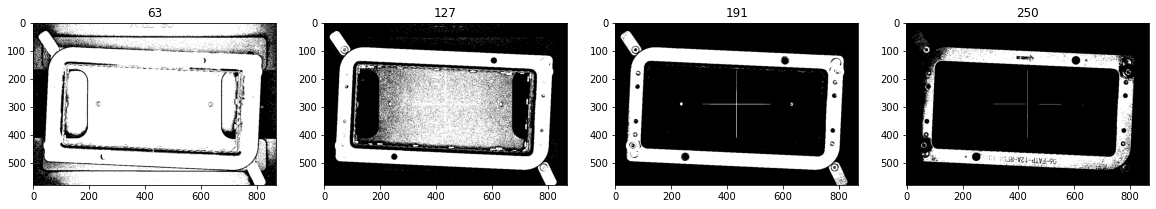

In [4]:
imgBin63 = np.vectorize(lambda p:255*(p>63))(imgGray).astype(np.uint8) # int32->uint8
imgBin127 = np.vectorize(lambda p:255*(p>127))(imgGray).astype(np.uint8)
imgBin191 = np.vectorize(lambda p:255*(p>191))(imgGray).astype(np.uint8)
imgBin250 = np.vectorize(lambda p:255*(p>250))(imgGray).astype(np.uint8)

fig = plt.figure(figsize=(20,5))
fig.set_facecolor("white")
plt.subplot(1,4,1); plt.imshow(imgBin63, cmap='gray'); plt.title("63")
plt.subplot(1,4,2); plt.imshow(imgBin127, cmap='gray'); plt.title("127")
plt.subplot(1,4,3); plt.imshow(imgBin191, cmap='gray'); plt.title("191")
plt.subplot(1,4,4); plt.imshow(imgBin250, cmap='gray'); plt.title("250")
plt.show()

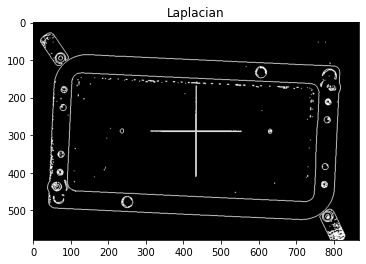

In [5]:
lap = cv2.Laplacian(imgBin191, cv2.CV_64F)
lap = np.uint8(np.absolute(lap))
fig = plt.figure()
fig.set_facecolor("white")
plt.title("Laplacian")
plt.imshow(lap, cmap="gray")
plt.show()

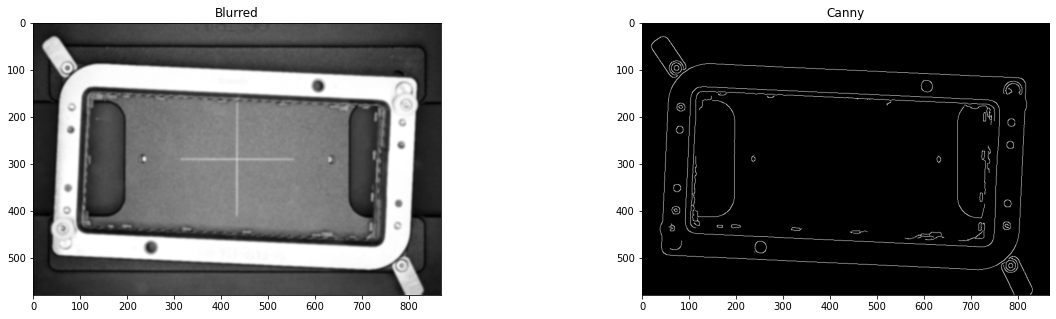

In [6]:
blurred = cv2.GaussianBlur(imgGray, (11, 11), 0)
edged = cv2.Canny(blurred, 30, 150)
fig = plt.figure(figsize=(20,5))
fig.set_facecolor("white")
plt.subplot(1,2,1)
plt.title("Blurred")
plt.imshow(blurred, cmap="gray")
plt.subplot(1,2,2)
plt.title("Canny")
plt.imshow(edged, cmap="gray")
plt.show()

In [11]:
contours1, hierarchy1 = cv2.findContours(lap.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for item in contours1:
    print(item.shape[0], end=" ")

print()
contours2, hierarchy2 = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for item in contours2:
    print(item.shape[0], end=" ")

144 8 575 4 4 133 
120 21 64 141 372 33 282 

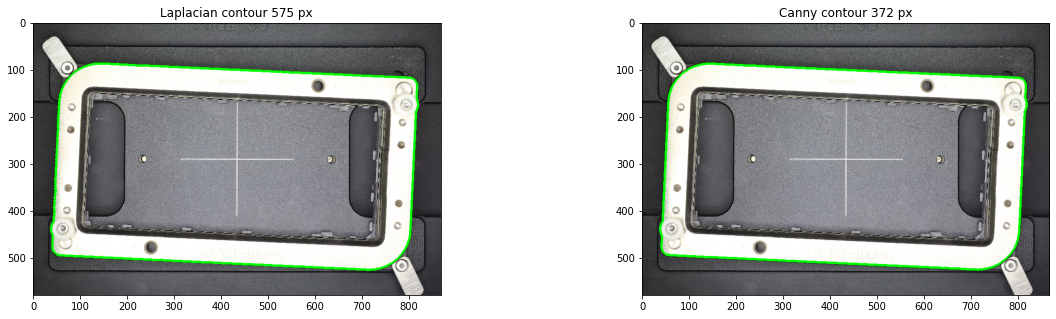

In [14]:
maxidx1 = np.argmax( [ item.shape[0] for item in contours1 ] )
maxidx2 = np.argmax( [ item.shape[0] for item in contours2 ] )

fig = plt.figure(figsize=(20,5))
fig.set_facecolor("white")
plt.subplot(1,2,1)
plt.title(f"Laplacian contour {contours1[maxidx1].shape[0]} px")
plt.imshow( cv2.drawContours(img.copy(), [contours1[maxidx1]], 0, (0,255,0), 3) )
plt.subplot(1,2,2)
plt.title(f"Canny contour {contours2[maxidx2].shape[0]} px")
plt.imshow( cv2.drawContours(img.copy(), [contours2[maxidx2]], 0, (0,255,0), 3) )
plt.show()

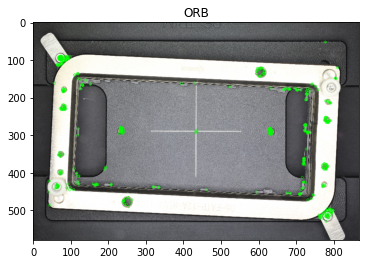

In [15]:
orb = cv2.ORB_create()
kp = orb.detect(img, None)
kp, des = orb.compute(img, kp)
dotImg = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.figure().set_facecolor("white")
plt.title("ORB")
plt.imshow(dotImg)
plt.show()

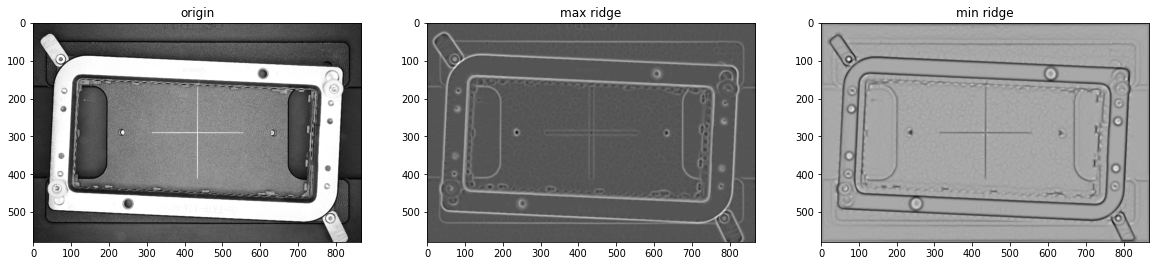

In [16]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

H_elems = hessian_matrix(imgGray, sigma=3.0, order='rc')
maxr, minr = hessian_matrix_eigvals(H_elems)

fig = plt.figure(figsize=(20,5))
fig.set_facecolor("white")
for i,name,image in [(0,"origin",imgGray), (1,"max ridge",maxr), (2,"min ridge",minr)]:
    plt.subplot(1,3,i+1)
    plt.title(name)
    plt.imshow(image, cmap='gray')
plt.show()

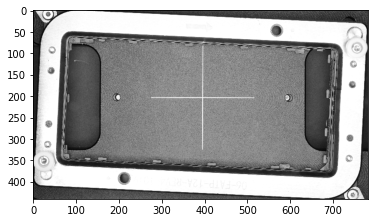

In [24]:
x, y, w, h = cv2.boundingRect(contours1[maxidx])
recImg = imgGray[y:y+h,x:x+w]
plt.figure().set_facecolor("white")
plt.imshow(recImg, cmap="gray")
plt.show()

In [25]:
(centerx, centery), (w, h), angle = cv2.minAreaRect(contours1[maxidx])
print(centerx, centery, w, h, angle)

428.4967346191406 305.0696105957031 768.1694946289062 413.9710693359375 2.6630008220672607


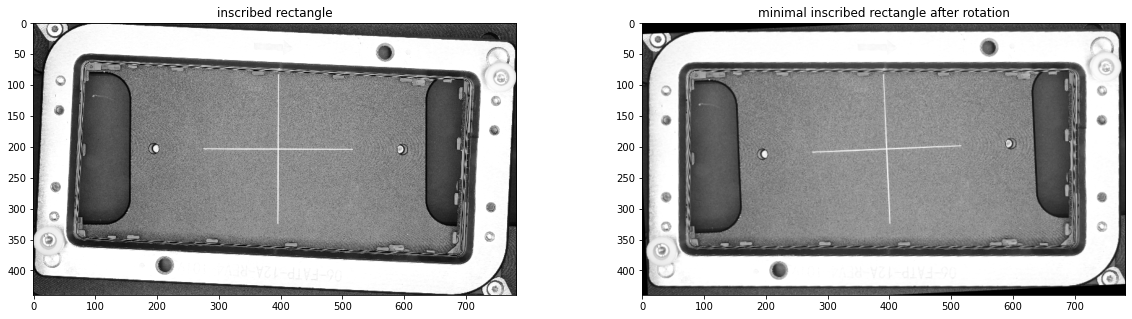

In [35]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    return cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

rotImg = rotate_image(recImg, angle)
fig = plt.figure(figsize=(20,5))
fig.set_facecolor("white")
plt.subplot(1,2,1)
plt.title("inscribed rectangle")
plt.imshow(recImg, cmap="gray")
plt.subplot(1,2,2)
plt.title("minimal inscribed rectangle after rotation")
plt.imshow(rotImg, cmap="gray")
plt.show()

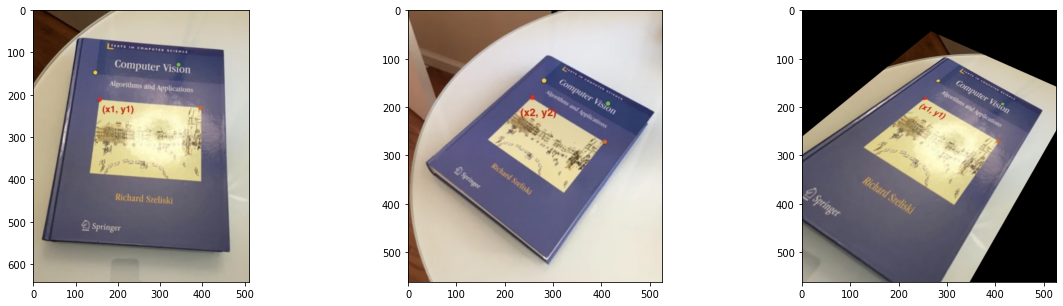

In [17]:
book1 = cv2.imread(r"C:\Users\James\Desktop\Code\python0\book1.png")
book2 = cv2.imread(r"C:\Users\James\Desktop\Code\python0\book2.png")
L1 = np.array([[341,128], [146,146], [157,209], [395,231]])
L2 = np.array([[413,193], [281,145], [255,181], [405,271]])

h, status = cv2.findHomography(L1, L2)
book12 = cv2.warpPerspective(book1, h, (book2.shape[1],book2.shape[0]))

fig = plt.figure(figsize=(20,5))
fig.set_facecolor("white")
for i,image in enumerate([book1,book2,book12]):
    plt.subplot(1,3,i+1)
    plt.imshow(rgb2bgr(image))
plt.show()

In [ ]:
class DFS:
    pass    